In [62]:
# BEWARE cuda is an uncontrolled mess
# This script loads games that have been trained for communication, then runs and saves communication for all available agent pairs
from egg.zoo.pop.games import build_game
from egg.zoo.pop.utils import load_from_checkpoint

# import sys
import pathlib
import numpy as np # :( is it really needed ??

#drawing and plotting
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

# import glob
import torch
from egg.core.batch import Batch
from egg.core.interaction import Interaction
from egg.zoo.pop.data import get_dataloader
from egg.zoo.pop.utils import get_common_opts, metadata_opener, path_to_parameters

# PCA
from sklearn.decomposition import PCA
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import pandas as pd
from sklearn.cluster import KMeans



In [110]:
def eval(
    sender,
    sender_input,
    device="cuda",
):
    """
    For a sender show all images with their corresponding saliency map
    """
    messages = sender(sender_input.to(device), {})
    sender.zero_grad()
    messages.mean().backward()
    saliencies = [torch.max(sender_input.grad[i].data.abs().to("cpu"), dim=0) for i in range(len(messages))]
    return messages.detach().to("cpu"), saliencies

def display_saliency_and_image(image, saliency):
    # Visualize the image and the saliency map
    # TODO : colour differences might be relevant to take into account
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image.cpu().detach().numpy().transpose(1, 2, 0))
    ax[0].axis('off')
    ax[1].imshow(saliency, cmap='hot')
    ax[1].axis('off')
    plt.tight_layout()
    fig.suptitle('The Image and Its Saliency Map')
    plt.show()

def display_saliency(image, saliency):
    # Visualize the saliency map
    # TODO : colour differences might be relevant to take into account
    fig, ax = plt.subplots(1, 1)
    ax.imshow(saliency, cmap='hot')
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
def get_senders(path):
    f = open(path_to_parameters(path, "wandb"))
    opts = get_common_opts(metadata_opener(f, data_type="wandb", verbose=True))
    exp_name = (
        str(opts.dataset_name)
        + (str(opts.noisy_channel) if opts.noisy_channel != None else "")
        + str(opts.augmentation_type)
        + str(opts.vision_model_names_senders)
        + str(opts.vision_model_names_recvs)
    )
    pop_game = build_game(opts)
    load_from_checkpoint(pop_game, path)
    return pop_game.agents_loss_sampler.senders

def reset_dataloader(opts, batch_size=None):
    _, train_loader = get_dataloader(
        dataset_dir=opts.dataset_dir,
        dataset_name=opts.dataset_name,
        image_size=opts.image_size,
        batch_size=2,#opts.batch_size,
        num_workers=0,
        is_distributed=opts.distributed_context.is_distributed,
        seed=111,  # same as hardcoded version used in experiments
        use_augmentations=opts.use_augmentations,
        return_original_image=opts.return_original_image,
        split_set=True,
        augmentation_type=opts.augmentation_type,
        is_single_class_batch=opts.is_single_class_batch,
    )
    return train_loader

In [65]:
# saliency from any model for a specific message
device = "cuda"
model_paths = ["/homedtcl/mmahaut/projects/experiments/im1k_cont/212452/final.tar"]
senders = [get_senders(path) for path in model_paths]
# add a control to check they all have the same data 
# temp solution this is suboptimal, I already got all the opts when getting the sender
f = open(path_to_parameters(model_paths[0], "wandb"))
opts = get_common_opts(metadata_opener(f, data_type="wandb", verbose=True))
    
dataloader = reset_dataloader(opts)
messages = []
saliencies = []
labels = []
for s_idx, sender in enumerate(senders[0]):
    sender = sender.to(device)
    for batch in dataloader:
        sender_input = batch[0].requires_grad_()
        message, saliency = eval(sender,sender_input)
        saliencies.append(saliency)
        messages.append(message)
        labels.append(batch[1])
        if len(messages) >= (s_idx +1)* 5000:
            break
    # remove the following break if you want messages from different senders
    break
print(len(messages))
# saliencies = np.concatenate(saliencies)
# messages = np.concatenate(messages)
# messages = np.concatenate(labels)

initialize module vgg11
initialize module vit
initialize module inception
initialize module swin
initialize module resnet152
initialize module dino
['vgg11', 'vit', 'resnet152', 'inception', 'dino', 'swin']
['vgg11', 'vit', 'resnet152', 'inception', 'dino', 'swin']
# loading trainer state from /homedtcl/mmahaut/projects/experiments/im1k_cont/212452/final.tar
50000
5000


10000 10000 5000


Text(0.5, 1.0, 'human_labels')

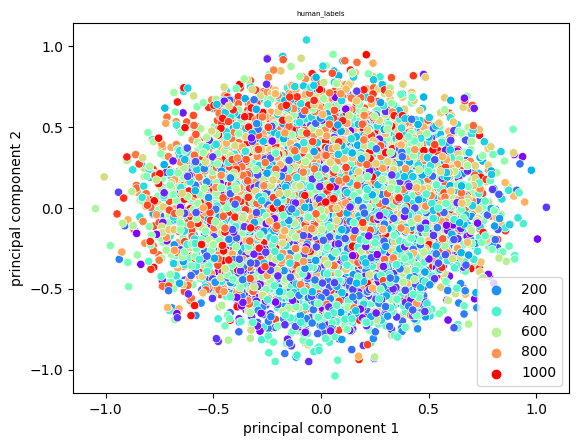

In [66]:
# do PCA
# PCA
n_components = 10
pca = PCA(n_components)

principalComponents = pca.fit_transform(torch.cat(messages))

df_pca = pd.DataFrame(data = principalComponents
            , columns = [f'principal component {i+1}' for i in range(n_components)])
## If we were to reuse those dimensions, this is what they look like : 
# print(df_pca[['principal component 1','principal component 2']].sample(3))

# plotting PCA
prin_comp_A = 1
prin_comp_B = 2
print(len(df_pca[f'principal component {prin_comp_A}']),len(df_pca[f'principal component {prin_comp_B}']),len(labels))
sns.scatterplot(x=df_pca[f'principal component {prin_comp_A}'],
    y=df_pca[f'principal component {prin_comp_B}'], 
    hue = torch.cat(labels),
    palette='rainbow',
).set_title("human_labels", fontsize = 5)

In [ ]:
# do normal clustering before PCA, then have PCA, then show.

n_classes =  999


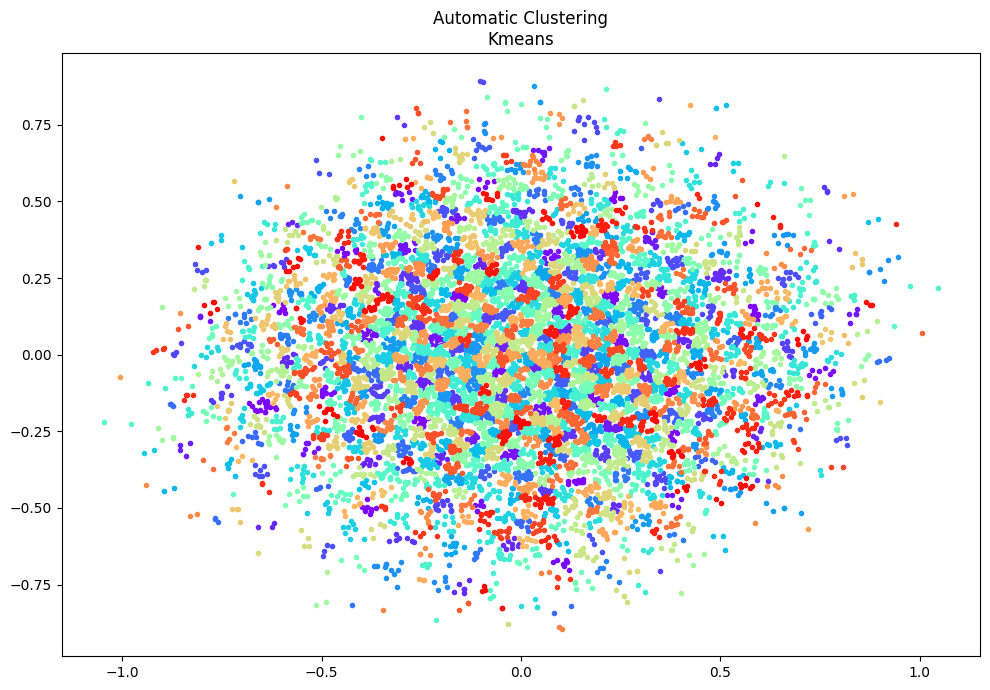

In [68]:
# do clustering
# clustering the PCA
X_pca = df_pca.loc[:,df_pca.columns.str.contains('1' or "2" or "3" or "4")].values
clust2 = KMeans(1000)
clust2.fit(X_pca)

# PLOT
# set colors
color = iter(plt.cm.rainbow(np.linspace(0, 1, max(clust2.labels_))))
# plot figure
plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(1, 1)
ax = plt.subplot(G[0, :])
# ax.plot(space, np.full_like(space, 1.0, dtype=float), "k.", alpha=0.3)
print("n_classes = ",max(clust2.labels_))
colors = plt.cm.get_cmap("hsv", max(clust2.labels_))
for klass in range(max(clust2.labels_)):
    Xk = X_pca[clust2.labels_ == klass]
    c = next(color)
    ax.plot(Xk[:, 0], Xk[:, 1], ".", color=c)
ax.plot(X_pca[clust2.labels_ == -1, 0], X_pca[clust2.labels_ == -1, 1], "k+", alpha=0.1)
ax.set_title("Automatic Clustering\nKmeans")
plt.tight_layout()
plt.show()

In [78]:
# do it again with the human clusters

tensor([[[[0.1216, 0.0902, 0.0588,  ..., 0.2471, 0.2863, 0.3137],
          [0.1020, 0.0588, 0.0510,  ..., 0.2353, 0.2275, 0.2118],
          [0.0471, 0.0510, 0.0510,  ..., 0.3255, 0.2824, 0.3176],
          ...,
          [0.5843, 0.6157, 0.6745,  ..., 0.5059, 0.4078, 0.3765],
          [0.6314, 0.6667, 0.7412,  ..., 0.4196, 0.4588, 0.4627],
          [0.5333, 0.6235, 0.7608,  ..., 0.3882, 0.4353, 0.4588]],

         [[0.1569, 0.1451, 0.1059,  ..., 0.2627, 0.2980, 0.3255],
          [0.1373, 0.1137, 0.1020,  ..., 0.2667, 0.2588, 0.2392],
          [0.0706, 0.1020, 0.1059,  ..., 0.3412, 0.2941, 0.3216],
          ...,
          [0.6314, 0.6784, 0.7098,  ..., 0.5451, 0.4588, 0.4275],
          [0.6510, 0.7059, 0.7569,  ..., 0.4549, 0.5137, 0.5137],
          [0.5255, 0.6353, 0.7490,  ..., 0.4118, 0.4784, 0.5098]],

         [[0.0863, 0.0745, 0.0471,  ..., 0.1843, 0.2275, 0.2549],
          [0.0745, 0.0549, 0.0510,  ..., 0.1765, 0.1686, 0.1569],
          [0.0275, 0.0549, 0.0627,  ..., 0

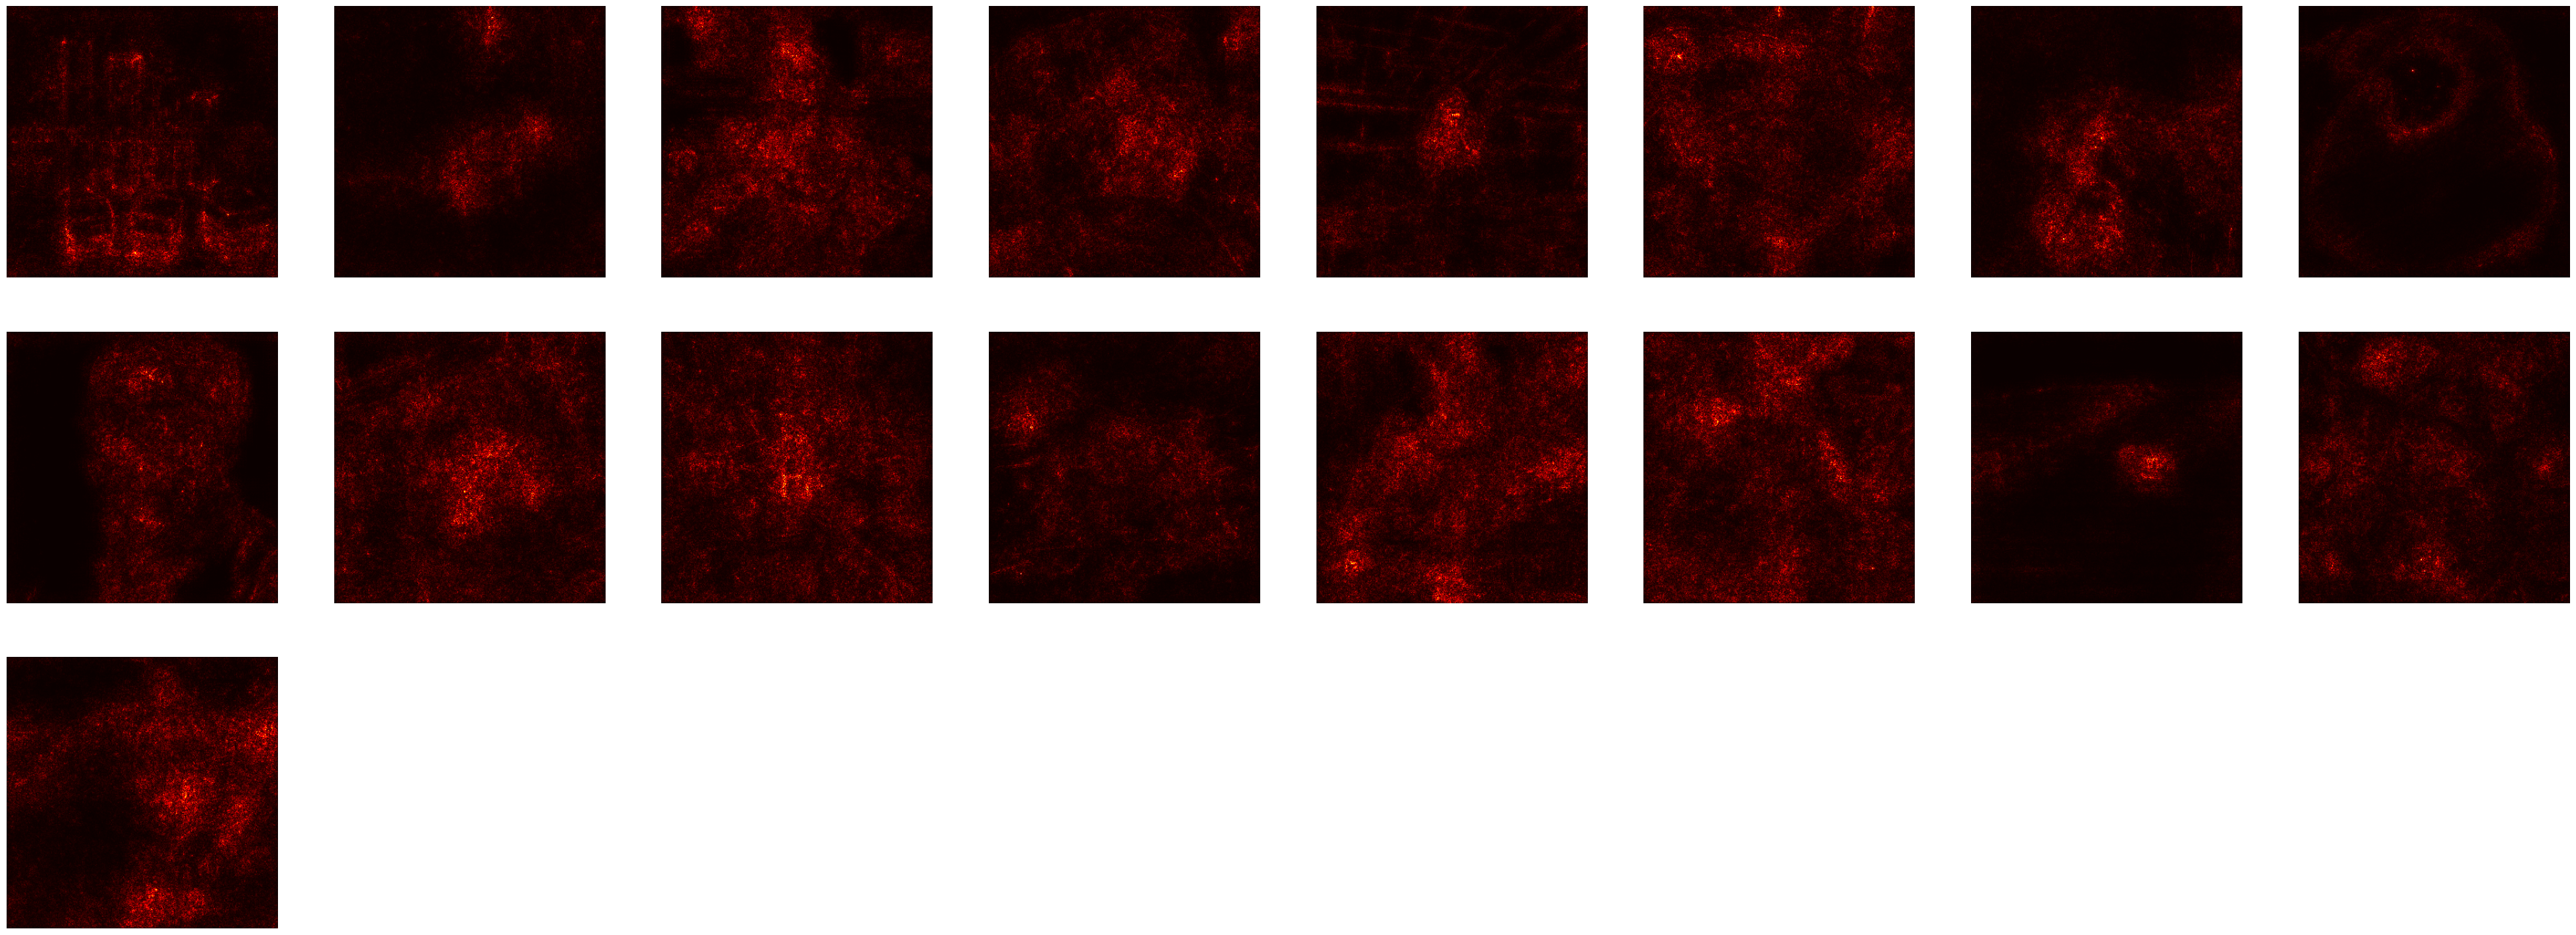

In [120]:
# show the saliency maps of the chosen clusters

def plot_batch(batch):
    fig = plt.figure(figsize=(50, 50))
    for i,im in enumerate(batch):
        if i > 63:
            print("error, batch seems to be above 64")
            break
        sub = fig.add_subplot(8, 8, i+1)
        plt.imshow(im, cmap='hot')
        plt.axis('off')
    plt.show()
        
clst_number = 3
plot_batch([np.concatenate(saliencies)[idx][0] for idx in np.where(clust2.labels_ == clst_number)[0]])
